In [1]:
# import packages
import pandas as pd
import os
import glob
import random
import numpy as np
import statistics
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.patches as mpatches

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import norm

## Data Prep

In [2]:
# import word count .csv file from local path
path = r'/Users/spencersu/Desktop/Galena Park'
bchmrk = pd.read_csv(os.path.join(path, 'Galena Park Benchmark 2019-22.csv')) # 18010 rows × 14 columns
wrtlsn = pd.read_csv(os.path.join(path, 'Galena Park Writing Lesson 2019-22.csv')) #15601 rows × 14 columns

In [3]:
# check if there is null value in the word count column
bchmrk['Word Count'].isnull().any()
wrtlsn['Word Count'].isnull().any()

True

In [4]:
### data prep for bchmrk

# remove column: the first column "Unnamed: 0"
bchmrk = bchmrk.iloc[:,1:14]

## change data type into integer: 'Word Count' column
# drop nan for Word Count column
bchmrk = bchmrk.dropna(subset=['Word Count'])

# replace ',' with ''
bchmrk['Word Count'].replace(',','',regex=True,inplace=True)

# convert data type of word count column into integer
bchmrk['Word Count'] = bchmrk['Word Count'].astype(int)


# wordcnt dataset now has 17852 rows × 13 columns
# data retrieved on Apr 26, 2022

In [5]:
### data prep for wrtlsn

# remove column: the first column "Unnamed: 0"
wrtlsn = wrtlsn.iloc[:,1:14]

## change data type into integer: 'Word Count' column
# drop nan for Word Count column
wrtlsn = wrtlsn.dropna(subset=['Word Count'])

# replace ',' with ''
wrtlsn['Word Count'].replace(',','',regex=True,inplace=True)

# convert data type of word count column into integer
wrtlsn['Word Count'] = wrtlsn['Word Count'].astype(int)


# wordcnt dataset now has 15109 rows × 13 columns
# data retrieved on Apr 26, 2022

In [6]:
wrtlsn

,Submission Date Date,School Year,School Name,Class Name,Lesson Type,Class Subject,Teacher Name [Sensitive],Student ID,Full Name,Enrolled Grade,Lesson ID,Student Assignment ID,Word Count
0,2019-09-10,2019-2020,North Shore Middle,7th Period,Writing Lesson,Unknown,NaN,939116,Cristopher Mendoza Mendoza,9.0,24673,12350019,84
1,2019-09-10,2019-2020,North Shore Middle,7th Period,Writing Lesson,Unknown,NaN,939223,Jesse Rodriguez,8.0,24673,12350026,61
2,2019-09-11,2019-2020,Cunningham Middle,3A/B College/Career Readiness A,Writing Lesson,ELA,NaN,938810,A'Sean Duhon,10.0,24749,12364614,24
3,2019-09-11,2019-2020,North Shore Middle,4th Period,Writing Lesson,other,NaN,936181,Gianna Alvizures,8.0,24673,12331694,92
4,2019-09-11,2019-2020,North Shore Middle,4th Period,Writing Lesson,other,NaN,936281,Magali Bolanos,9.0,24673,12331695,226
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15596,2022-04-25,2021-2022,Cunningham Middle,3rd Pd Think Tank,Writing Lesson,ELA,Kimberly Lane,1241961,Devin Bonhame,7.0,20619,16984880,235
15597,2022-04-25,2021-2022,Cunningham Middle,3rd Pd Think Tank,Writing Lesson,ELA,Kimberly Lane,1244427,Enrique Medellin,7.0,20619,16984882,320
15598,2022-04-25,2021-2022,Cunningham Middle,3rd Pd Think Tank,Writing Lesson,ELA,Kimberly Lane,1244856,Amelia Rosales Rubio,7.0,20619,16984883,411
15599,2022-04-25,2021-2022,Cunningham Middle,3rd Pd Think Tank,Writing Lesson,ELA,Kimberly Lane,1250764,Ronell Brown,7.0,20619,16984884,182


## Data Overview

In [52]:
## count student assignments and students 
## p.s. the number of students and the number of benchmarks should be the same
## count total writing lessons 

print(bchmrk.groupby(['School Year','Lesson Type','Enrolled Grade'])['Student Assignment ID'].nunique())
# bchmrk.groupby(['School Year','Lesson Type','Enrolled Grade'])['Student Assignment ID'].nunique().to_csv(os.path.join(path,"student number bm.csv"))
print(bchmrk.groupby(['School Year','Lesson Type'])['Student Assignment ID'].nunique())
print(bchmrk.groupby(['School Year'])['Student Assignment ID'].nunique())
print(wrtlsn.groupby(['School Year','Enrolled Grade'])['Student Assignment ID', 'Student ID'].nunique())
# wrtlsn.groupby(['School Year','Enrolled Grade'])['Student Assignment ID', 'Student ID'].nunique().to_csv(os.path.join(path,"student number and lessons.csv"))
print(wrtlsn.groupby(['School Year'])['Student Assignment ID','Student ID'].nunique())

School Year  Lesson Type                   Enrolled Grade
2019-2020    Benchmark - Baseline Writing  7.0                 85
                                           8.0               1366
                                           9.0                490
                                           10.0               271
                                           11.0                74
                                           12.0               167
             Benchmark - Mid-Year          7.0                 81
                                           8.0               1658
                                           9.0                522
                                           10.0               406
                                           11.0               114
                                           12.0               192
2020-2021    Benchmark - Baseline Writing  7.0                 60
                                           8.0               1736
                  

In [9]:
## average word count overview
## p.s. not removing outliers yet
print(wrtlsn.groupby(['School Year','Enrolled Grade'])['Word Count'].mean())#.to_csv(os.path.join(path, 'Word Count Overview.csv'))
print(bchmrk.groupby(['School Year','Lesson Type','Enrolled Grade'])['Word Count'].mean())#.to_csv(os.path.join(path, 'word count bm.csv'))
# bchmrk.groupby(['School Year','Lesson Type','Enrolled Grade'])['Word Count'].mean().to_csv(os.path.join(path, 'word count bm.csv'))

School Year  Enrolled Grade
2019-2020    3.0                71.000000
             7.0               168.740964
             8.0               161.954501
             9.0               165.988413
             10.0              149.634312
             11.0              157.445860
             12.0              130.231608
2020-2021    7.0               140.505263
             8.0               191.672537
             9.0               207.587302
             10.0              342.285714
             11.0               36.000000
             12.0               93.000000
2021-2022    7.0               207.834521
             8.0               240.268688
             9.0               202.678571
             10.0              179.372549
             11.0              169.750000
             12.0              305.000000
Name: Word Count, dtype: float64
School Year  Lesson Type                   Enrolled Grade
2019-2020    Benchmark - Baseline Writing  7.0                57.696629
           

In [56]:
# bchmrk.groupby(['School Year','Lesson Type','Enrolled Grade'])['Word Count'].mean().to_csv(os.path.join(path, 'word count bm.csv'))
# bchmrk.groupby(['School Year','Lesson Type'])['Word Count'].mean().to_csv(os.path.join(path, 'word count bm overall.csv'))

In [10]:
# remove outliers for word count based on both year and lesson type
def remove_outlier(df, column1, n1, column2, n2, y):
    g = df[(df[column1] == df[column1].unique()[n1]) & (df[column2] == df[column2].unique()[n2])]
    z = np.abs(stats.zscore(g[y]))
    g['z'] = z
    # threshold = 3
    g = g[g['z']<3]
    g.drop(['z'],axis=1,inplace=True)
    return g

In [11]:
sub = []
for n1 in range(0,3):
        for n2 in range (0,3):
            g = remove_outlier(bchmrk, 'School Year', n1, 'Lesson Type', n2, 'Word Count')
            sub.append(g)

bchmrk = pd.concat(sub, axis=0, ignore_index=True)
# 17594 rows × 13 columns

In [12]:
bchmrk.groupby(['School Year','Enrolled Grade', 'Lesson Type'])['Word Count'].mean()#.to_csv(os.path.join(path, 'word count (no outlier) bm.csv'))

School Year  Enrolled Grade  Lesson Type                 
2019-2020    7.0             Benchmark - Baseline Writing     46.317647
                             Benchmark - Mid-Year            122.012346
             8.0             Benchmark - Baseline Writing     49.348463
                             Benchmark - Mid-Year            163.574186
             9.0             Benchmark - Baseline Writing     49.695918
                             Benchmark - Mid-Year            157.293103
             10.0            Benchmark - Baseline Writing     46.778598
                             Benchmark - Mid-Year            147.098522
             11.0            Benchmark - Baseline Writing     52.270270
                             Benchmark - Mid-Year            142.710526
             12.0            Benchmark - Baseline Writing     48.377246
                             Benchmark - Mid-Year            137.625000
2020-2021    7.0             Benchmark - Baseline Writing     39.283333
      

In [13]:
bchmrk.groupby(['School Year','Lesson Type'])['Word Count'].mean()

School Year  Lesson Type                 
2019-2020    Benchmark - Baseline Writing     49.050958
             Benchmark - Mid-Year            156.613185
2020-2021    Benchmark - Baseline Writing     44.138773
             Benchmark - End-of-Year         197.464286
             Benchmark - Mid-Year            159.145717
2021-2022    Benchmark - Baseline Writing     91.600438
             Benchmark - Mid-Year            211.696732
Name: Word Count, dtype: float64

In [14]:
bchmrk.groupby(['School Name','Teacher Name [Sensitive]','Lesson Type'])['Word Count'].mean()

School Name              Teacher Name [Sensitive]  Lesson Type                 
CTE ECHS                 Amy Noblitt               Benchmark - Baseline Writing    233.000000
Cunningham Middle        Angela Glynn              Benchmark - Baseline Writing     43.903614
                                                   Benchmark - Mid-Year            152.775330
                         Avery Wilson              Benchmark - Baseline Writing     44.123077
                                                   Benchmark - Mid-Year            238.494845
                         Kimberly Lane             Benchmark - Baseline Writing    113.323077
                                                   Benchmark - Mid-Year            239.271605
Galena Park High         Stacey Neal               Benchmark - Baseline Writing    122.590909
North Shore Middle       Jovanna David             Benchmark - Baseline Writing     53.336449
                                                   Benchmark - Mid-Year   

In [57]:
# bchmrk.to_csv(os.path.join(path, 'graphs bm.csv'))

In [53]:
bchmrk

,Submission Date Date,School Year,School Name,Class Name,Lesson Type,Class Subject,Teacher Name [Sensitive],Student ID,Full Name,Enrolled Grade,Lesson ID,Student Assignment ID,Word Count
0,2019-08-27,2019-2020,Cunningham Middle,3rd Think TANK,Benchmark - Baseline Writing,other,NaN,935623,Christian Chavez,8.0,24546,12141640,20
1,2019-08-27,2019-2020,Cunningham Middle,3rd Think TANK,Benchmark - Baseline Writing,other,NaN,936613,Breanna Robles,8.0,24546,12141343,12
2,2019-08-27,2019-2020,Cunningham Middle,3rd Think TANK,Benchmark - Baseline Writing,other,NaN,936648,Darian Gonzalez,8.0,24546,12141351,29
3,2019-08-27,2019-2020,Cunningham Middle,3rd Think TANK,Benchmark - Baseline Writing,other,NaN,936715,Aldo Urbina,8.0,24546,12141436,40
4,2019-08-27,2019-2020,Cunningham Middle,3rd Think TANK,Benchmark - Baseline Writing,other,NaN,936735,Omar Salazar,8.0,24546,12141404,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17589,2022-01-19,2021-2022,Galena Park Middle,HS9181/002 - CCR A,Benchmark - Mid-Year,ELA,NaN,1133064,Xavier Montoya,8.0,26395,16390536,148
17590,2022-01-19,2021-2022,Galena Park Middle,MS1770/013 - Think TANK,Benchmark - Mid-Year,Unknown,NaN,1173088,Ta'Kyra Johnson,7.0,26387,16385472,83
17591,2022-01-19,2021-2022,Galena Park Middle,MS1770/014 - Think TANK,Benchmark - Mid-Year,Unknown,NaN,1171658,Christopher Reyes,7.0,30387,16385479,185
17592,2022-01-19,2021-2022,Galena Park Middle,MS1770/014 - Think TANK,Benchmark - Mid-Year,Unknown,NaN,1172230,Sebastian Deciga,7.0,30387,16385481,352


## T-test

In [16]:
# reshape the dataset so that BOY and MOY can be two columns side by side 

bchmrk_p = bchmrk.pivot_table(index=['School Year', 'School Name', 'Full Name','Enrolled Grade'], 
                              columns='Lesson Type', values='Word Count')
bchmrk_p = bchmrk_p.reset_index()

bchmrk_p = bchmrk_p.dropna()

print(bchmrk_p[['Benchmark - Baseline Writing','Benchmark - Mid-Year']].describe())
print(ttest_rel(bchmrk_p['Benchmark - Baseline Writing'], bchmrk_p['Benchmark - Mid-Year']))

# bchmrk_p: 503 rows × 7 columns
## t-test results have shown that there is a difference between boy and moy, and the writing scores improve

Lesson Type  Benchmark - Baseline Writing  Benchmark - Mid-Year
count                         1280.000000           1280.000000
mean                            44.412109            184.644141
std                             35.637562            113.688626
min                              1.000000              1.000000
25%                             19.000000             96.000000
50%                             33.000000            171.500000
75%                             59.000000            257.250000
max                            187.000000            569.000000
Ttest_relResult(statistic=-46.38348974233122, pvalue=2.741507623143948e-276)


In [17]:
# matching sets word count mean and number of students 
print(bchmrk_p.groupby(['School Year','Enrolled Grade'])['Benchmark - Baseline Writing','Benchmark - Mid-Year'].mean())
print(bchmrk_p.groupby(['School Year','Enrolled Grade'])['Benchmark - Baseline Writing','Benchmark - Mid-Year'].count())

Lesson Type                 Benchmark - Baseline Writing  Benchmark - Mid-Year
School Year Enrolled Grade                                                    
2020-2021   7.0                                38.281250            153.156250
            8.0                                44.518908            184.391176
            9.0                                45.603448            207.206897
Lesson Type                 Benchmark - Baseline Writing  Benchmark - Mid-Year
School Year Enrolled Grade                                                    
2020-2021   7.0                                       32                    32
            8.0                                     1190                  1190
            9.0                                       58                    58


## Boxplots (just for viewing the structure)

<Figure size 720x576 with 0 Axes>

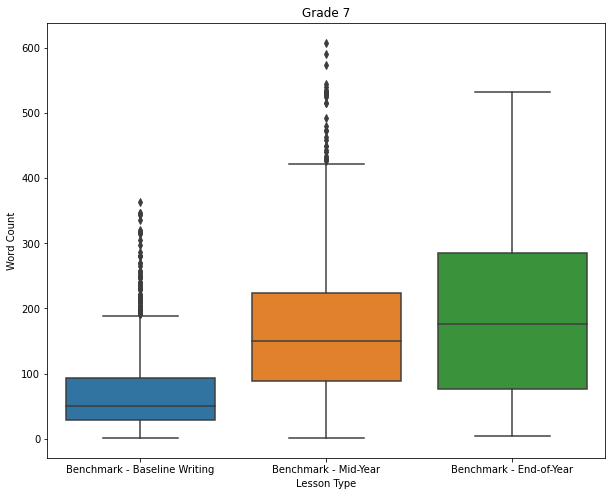

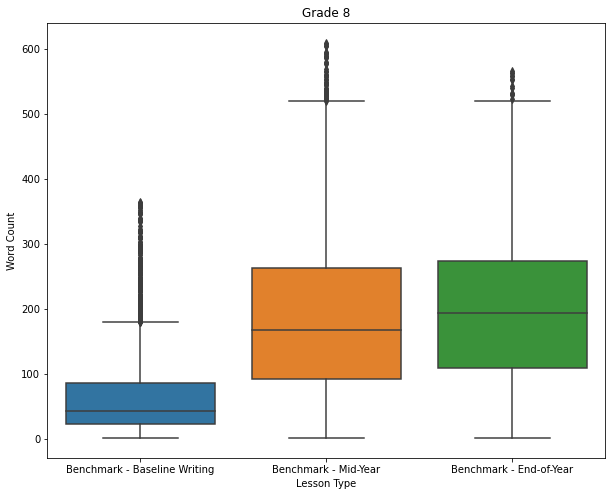

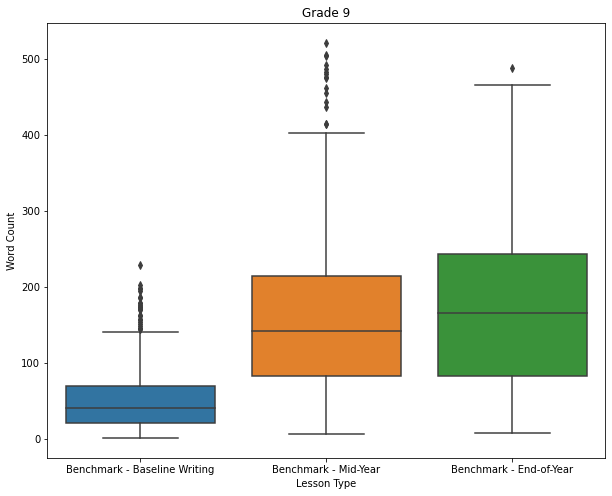

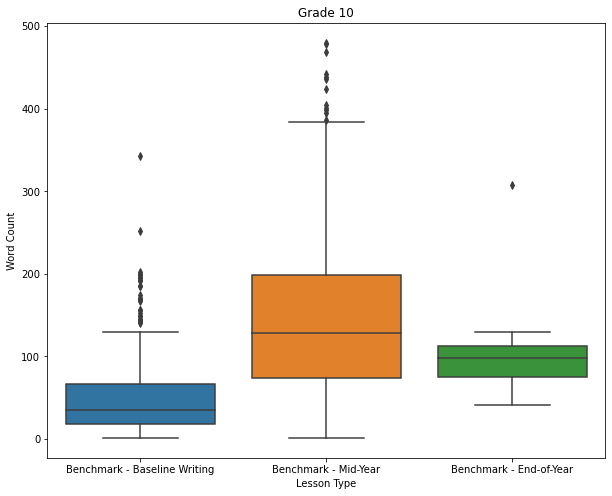

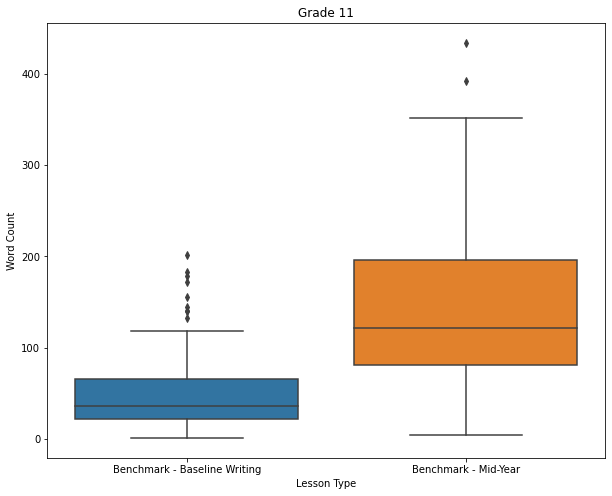

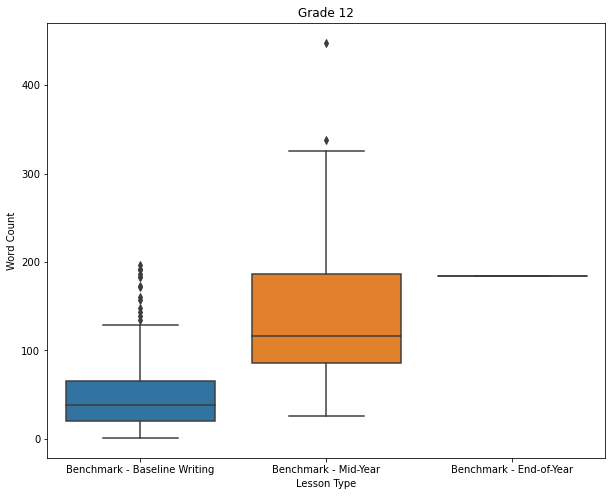

In [18]:
# boxplot: writing scores by boy, moy and eoy (for each grade)
plt.figure(figsize = (10,8))

for n in range(7,13): 
    plt.figure(figsize = (10,8))
    # choose the grade  
    grade = bchmrk[bchmrk['Enrolled Grade']==n] 
    
    ax = sns.boxplot(x=grade['Lesson Type'],y=grade['Word Count'])
    ax.set_title('Grade %d' %n)
#     plt.savefig('/Users/spencersu/Desktop/JCPS Efficacy Report/Datasets/boxplot grade' + str(n) +'.png')
    plt.show()

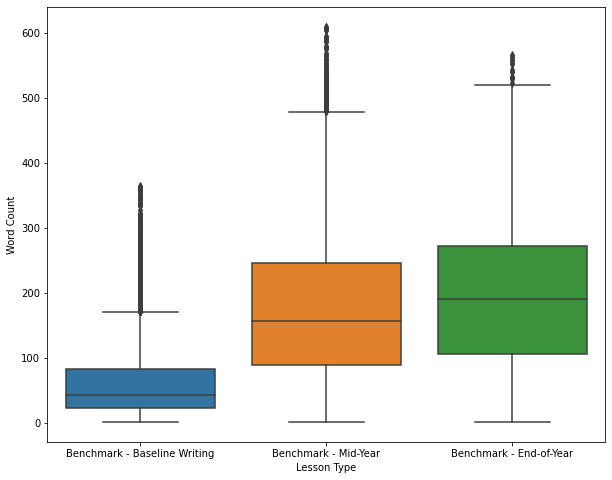

In [19]:
plt.figure(figsize = (10,8))
ax = sns.boxplot(x=bchmrk['Lesson Type'],y=bchmrk['Word Count'])
plt.show()

## Scatterplot (usage vs. word count)

In [20]:
bchmrk_p['growth'] = bchmrk_p['Benchmark - Mid-Year'] - bchmrk_p['Benchmark - Baseline Writing']

## count the number of writing lessons a student submit 

num_wrtlsn = wrtlsn.groupby(['School Year','School Name','Full Name','Enrolled Grade'])['Student Assignment ID'].count()
num_wrtlsn = num_wrtlsn.reset_index()
num_wrtlsn.rename(columns={'Student Assignment ID': 'num_asgmt'}, inplace = True)

bchmrk_p = pd.merge(bchmrk_p,num_wrtlsn,on=['School Year','School Name','Full Name','Enrolled Grade'], how='inner')

# 879 rows × 9 columns

In [21]:
# bchmrk_p = bchmrk_p[(bchmrk_p['Enrolled Grade'] == 8)]

# 830 rows × 9 columns

In [22]:
bchmrk_p

,School Year,School Name,Full Name,Enrolled Grade,Benchmark - Baseline Writing,Benchmark - End-of-Year,Benchmark - Mid-Year,growth,num_asgmt
0,2020-2021,Cunningham Middle,A'Zurious Booker,8.0,45.0,201.0,37.0,-8.0,4
1,2020-2021,Cunningham Middle,Alyssa Martinez,8.0,55.0,61.0,71.0,16.0,1
2,2020-2021,Cunningham Middle,Aniya Alexander-Mcgowen,8.0,26.0,191.0,81.0,55.0,1
3,2020-2021,Cunningham Middle,Anthony Delgadillo,8.0,20.0,121.0,107.0,87.0,2
4,2020-2021,Cunningham Middle,Anthony Vasquez,8.0,23.0,20.0,236.0,213.0,3
...,...,...,...,...,...,...,...,...,...
874,2020-2021,Woodland Acres Middle,Samantha Garza,8.0,28.0,223.0,307.0,279.0,10
875,2020-2021,Woodland Acres Middle,Savannah Roberts,8.0,32.0,489.0,122.0,90.0,1
876,2020-2021,Woodland Acres Middle,Seth Lopez,8.0,93.0,258.0,138.0,45.0,10
877,2020-2021,Woodland Acres Middle,Sofia Tellez,8.0,50.0,439.0,235.0,185.0,5


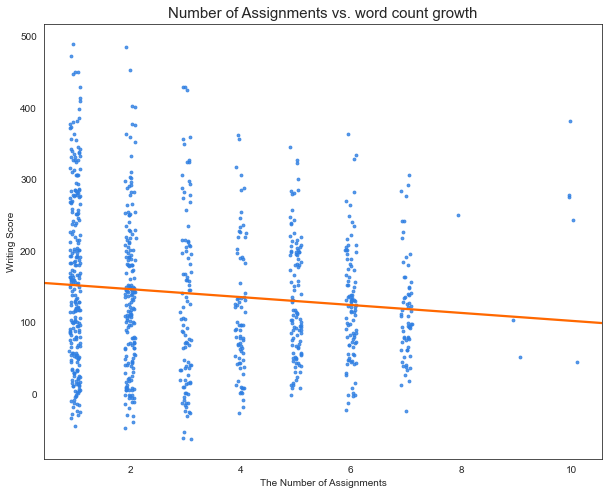

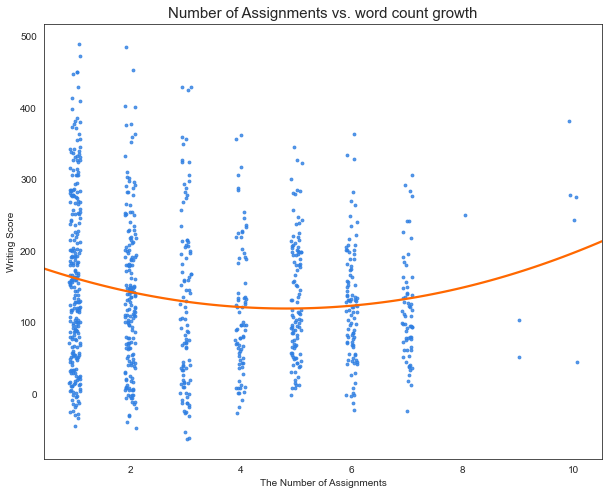

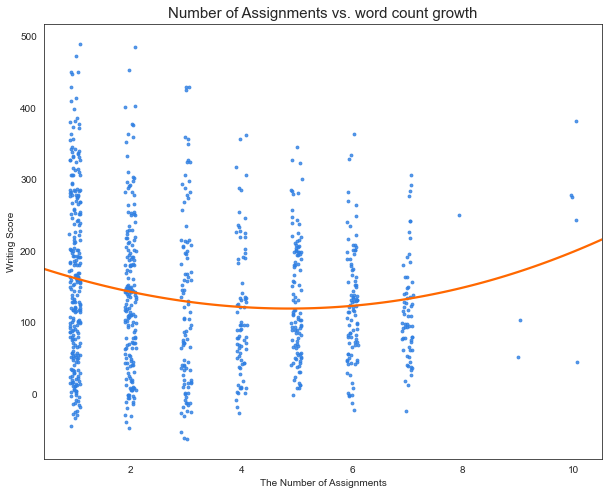

In [45]:
for n in range (1,4):
    sns.set_style(style='white')
    plt.figure(figsize = (10,8))
    sns.regplot(bchmrk_p['num_asgmt'],bchmrk_p['growth'], order = n,
                scatter_kws={"color": "#2f7fe2",'s':8}, truncate = False, x_jitter=.1,marker='o',
                line_kws={"color": "#ff6800"}, ci=None)
    plt.xlabel('The Number of Assignments')
    plt.ylabel('Writing Score')
    plt.title("Number of Assignments vs. word count growth", fontsize=15)
#     plt.savefig(os.path.join(path,'The Number of Assignments vs. MOY Writing Score (Order ' + str(n) +').png'))
    plt.show()

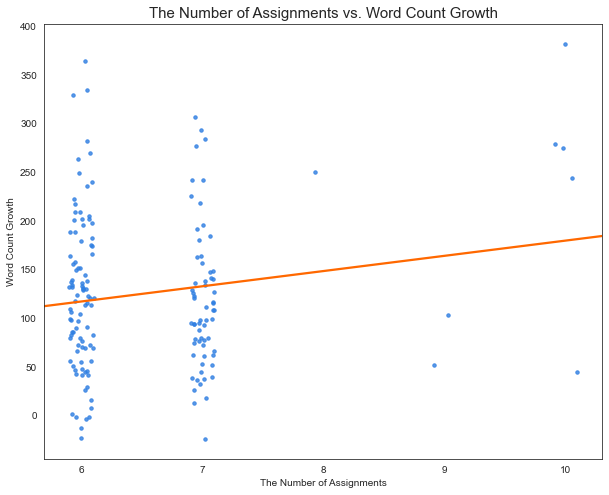

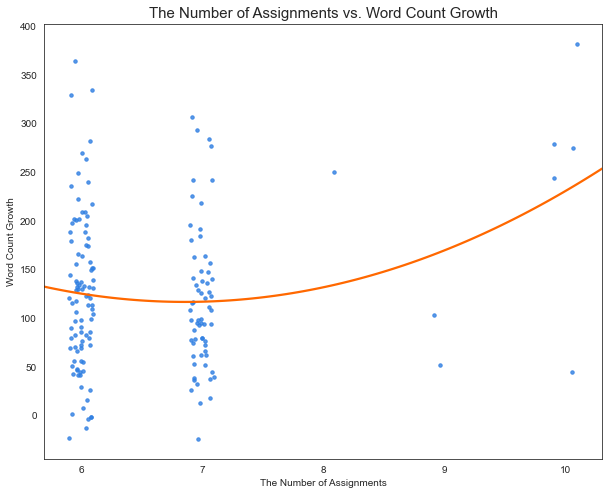

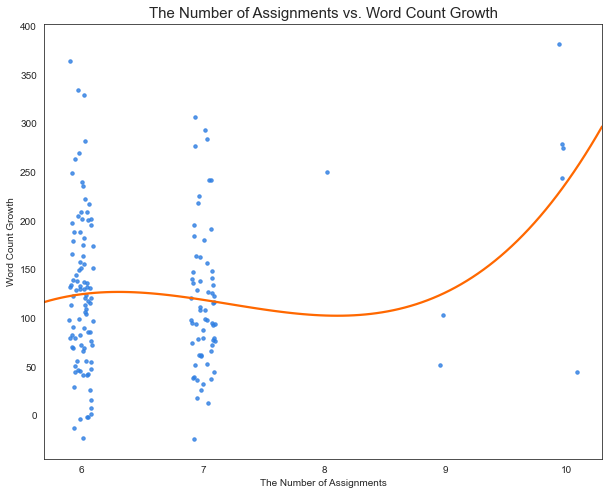

In [24]:
bchmrk_usage = bchmrk_p[bchmrk_p['num_asgmt'] >5]

for n in range (1,4):
    sns.set_style(style='white')
    plt.figure(figsize = (10,8))
    sns.regplot(bchmrk_usage['num_asgmt'],bchmrk_usage['growth'], order = n,
                scatter_kws={"color": "#2f7fe2",'s':12}, truncate = False, x_jitter=.1,marker='o',
                line_kws={"color": "#ff6800"}, ci=None)
    plt.xlabel('The Number of Assignments')
    plt.ylabel('Word Count Growth')
    plt.title("The Number of Assignments vs. Word Count Growth", fontsize=15)
    plt.savefig(os.path.join(path,'num asgmt vs. (overall) word count growth (order ' + str(n) +').png'))
    plt.show()

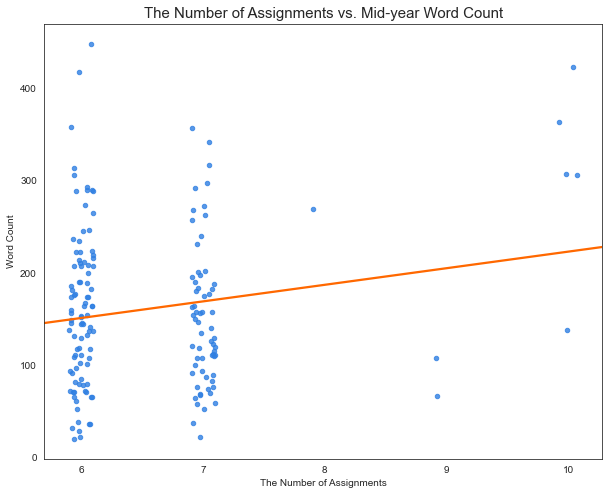

In [25]:
bchmrk_usage = bchmrk_p[bchmrk_p['num_asgmt'] >5]

sns.set_style(style='white')
plt.figure(figsize = (10,8))
sns.regplot(bchmrk_usage['num_asgmt'],bchmrk_usage['Benchmark - Mid-Year'], order = 1,
            scatter_kws={"color": "#2f7fe2",'s':20}, truncate = False, x_jitter=.1,marker='o',
            line_kws={"color": "#ff6800"}, ci=None)
plt.xlabel('The Number of Assignments')
plt.ylabel('Word Count')
plt.title("The Number of Assignments vs. Mid-year Word Count", fontsize=15)
# plt.savefig(os.path.join(path,'Assignments vs Word Count.png'))
plt.show()

## Regression (Usage vs. Scores)

In [26]:
df_reg = bchmrk_usage.rename(columns={bchmrk_usage.columns[0]: 'school_year', 
                                      bchmrk_usage.columns[1]: 'school_name',
                                      bchmrk_usage.columns[2]: 'full_name',
                                      bchmrk_usage.columns[3]: 'enrolled_grade',
                                      bchmrk_usage.columns[4]: 'baseline_wordcount',
                                      bchmrk_usage.columns[5]: 'endyear_wordcount',
                                      bchmrk_usage.columns[6]: 'midyear_wordcount'}, inplace = False)

In [27]:
df_reg2 = bchmrk_p.rename(columns={bchmrk_p.columns[0]: 'school_year', 
                                   bchmrk_p.columns[1]: 'school_name',
                                   bchmrk_p.columns[2]: 'full_name',
                                   bchmrk_p.columns[3]: 'enrolled_grade',
                                   bchmrk_p.columns[4]: 'baseline_wordcount',
                                   bchmrk_p.columns[5]: 'endyear_wordcount',
                                   bchmrk_p.columns[6]: 'midyear_wordcount'}, inplace = False)

In [28]:
results = smf.ols('growth ~ num_asgmt + C(school_name)', data=df_reg).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     6.227
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           0.000498
Time:                        16:31:09   Log-Likelihood:                -960.38
No. Observations:                 167   AIC:                             1929.
Df Residuals:                     163   BIC:                             1941.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [29]:
results2 = smf.ols('growth ~ num_asgmt + C(school_name)', data=df_reg2).fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     5.049
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           0.000502
Time:                        16:31:09   Log-Likelihood:                -5335.7
No. Observations:                 879   AIC:                         1.068e+04
Df Residuals:                     874   BIC:                         1.071e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [30]:
bchmrk_reg = pd.merge(bchmrk,num_wrtlsn,on=['School Year','School Name','Full Name','Enrolled Grade'], how='inner')

In [31]:
bchmrk_reg

,Submission Date Date,School Year,School Name,Class Name,Lesson Type,Class Subject,Teacher Name [Sensitive],Student ID,Full Name,Enrolled Grade,Lesson ID,Student Assignment ID,Word Count,num_asgmt
0,2019-08-27,2019-2020,Cunningham Middle,3rd Think TANK,Benchmark - Baseline Writing,other,NaN,935623,Christian Chavez,8.0,24546,12141640,20,3
1,2019-12-17,2019-2020,Cunningham Middle,3rd Think TANK,Benchmark - Mid-Year,other,NaN,935623,Christian Chavez,8.0,26176,13213192,164,3
2,2019-08-27,2019-2020,Cunningham Middle,3rd Think TANK,Benchmark - Baseline Writing,other,NaN,936613,Breanna Robles,8.0,24546,12141343,12,3
3,2019-09-11,2019-2020,Cunningham Middle,3rd Think TANK,Benchmark - Baseline Writing,other,NaN,936613,Breanna Robles,8.0,24546,12141341,11,3
4,2019-09-11,2019-2020,Cunningham Middle,3rd Think TANK,Benchmark - Baseline Writing,other,NaN,936613,Breanna Robles,8.0,24546,12141363,11,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10937,2021-12-17,2021-2022,Galena Park Middle,MS1770/011 - Think TANK,Benchmark - Mid-Year,Unknown,NaN,1173258,Gea Reyes-Garcia,7.0,26387,16398272,184,1
10938,2021-12-17,2021-2022,Woodland Acres Middle,MS1770/03 - Think TANK,Benchmark - Mid-Year,Unknown,Fredrika Aubrey,1172215,Kaelynn Garcia,7.0,26387,16441853,29,1
10939,2022-01-07,2021-2022,Galena Park Middle,MS1770/007 - Think TANK,Benchmark - Mid-Year,ELA,NaN,1250776,Adore Jackson,7.0,26387,16406769,27,2
10940,2022-01-19,2021-2022,Galena Park Middle,HS9181/002 - CCR A,Benchmark - Mid-Year,ELA,NaN,1133064,Xavier Montoya,8.0,26395,16390536,148,3


In [32]:
df_reg3 = bchmrk_reg.rename(columns={bchmrk_reg.columns[1]: 'school_year', 
                                     bchmrk_reg.columns[2]: 'school_name',
                                     bchmrk_reg.columns[8]: 'full_name',
                                     bchmrk_reg.columns[9]: 'enrolled_grade',
                                     bchmrk_reg.columns[4]: 'lesson_type',
                                     bchmrk_reg.columns[12]: 'word_count'}, inplace = False)

In [33]:
bchmrk_reg

,Submission Date Date,School Year,School Name,Class Name,Lesson Type,Class Subject,Teacher Name [Sensitive],Student ID,Full Name,Enrolled Grade,Lesson ID,Student Assignment ID,Word Count,num_asgmt
0,2019-08-27,2019-2020,Cunningham Middle,3rd Think TANK,Benchmark - Baseline Writing,other,NaN,935623,Christian Chavez,8.0,24546,12141640,20,3
1,2019-12-17,2019-2020,Cunningham Middle,3rd Think TANK,Benchmark - Mid-Year,other,NaN,935623,Christian Chavez,8.0,26176,13213192,164,3
2,2019-08-27,2019-2020,Cunningham Middle,3rd Think TANK,Benchmark - Baseline Writing,other,NaN,936613,Breanna Robles,8.0,24546,12141343,12,3
3,2019-09-11,2019-2020,Cunningham Middle,3rd Think TANK,Benchmark - Baseline Writing,other,NaN,936613,Breanna Robles,8.0,24546,12141341,11,3
4,2019-09-11,2019-2020,Cunningham Middle,3rd Think TANK,Benchmark - Baseline Writing,other,NaN,936613,Breanna Robles,8.0,24546,12141363,11,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10937,2021-12-17,2021-2022,Galena Park Middle,MS1770/011 - Think TANK,Benchmark - Mid-Year,Unknown,NaN,1173258,Gea Reyes-Garcia,7.0,26387,16398272,184,1
10938,2021-12-17,2021-2022,Woodland Acres Middle,MS1770/03 - Think TANK,Benchmark - Mid-Year,Unknown,Fredrika Aubrey,1172215,Kaelynn Garcia,7.0,26387,16441853,29,1
10939,2022-01-07,2021-2022,Galena Park Middle,MS1770/007 - Think TANK,Benchmark - Mid-Year,ELA,NaN,1250776,Adore Jackson,7.0,26387,16406769,27,2
10940,2022-01-19,2021-2022,Galena Park Middle,HS9181/002 - CCR A,Benchmark - Mid-Year,ELA,NaN,1133064,Xavier Montoya,8.0,26395,16390536,148,3


In [34]:
results3 = smf.ols('word_count ~ num_asgmt + C(school_name) + C(enrolled_grade) + C(lesson_type)', data=df_reg3).fit()
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:             word_count   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     348.9
Date:                Thu, 28 Apr 2022   Prob (F-statistic):               0.00
Time:                        16:31:09   Log-Likelihood:                -64930.
No. Observations:               10942   AIC:                         1.299e+05
Df Residuals:                   10926   BIC:                         1.300e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [50]:
nsm = df_reg2[df_reg2['school_name']=='North Shore Middle']

results4 = smf.ols('growth ~ C(enrolled_grade) + num_asgmt', data=nsm).fit()
print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     5.948
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           0.000558
Time:                        16:40:14   Log-Likelihood:                -2576.2
No. Observations:                 426   AIC:                             5160.
Df Residuals:                     422   BIC:                             5177.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [49]:
gpm = df_reg2[df_reg2['school_name']=='Galena Park Middle']

results5 = smf.ols('growth ~ C(enrolled_grade) + num_asgmt', data=gpm).fit()
print(results5.summary())

                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.6375
Date:                Thu, 28 Apr 2022   Prob (F-statistic):              0.592
Time:                        16:39:54   Log-Likelihood:                -1161.0
No. Observations:                 195   AIC:                             2330.
Df Residuals:                     191   BIC:                             2343.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [37]:
wam = df_reg2[df_reg2['school_name']=='Woodland Acres Middle']

results6 = smf.ols('growth ~ C(enrolled_grade) + num_asgmt', data=wam).fit()
print(results6.summary())

                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     7.544
Date:                Thu, 28 Apr 2022   Prob (F-statistic):            0.00162
Time:                        16:31:09   Log-Likelihood:                -259.17
No. Observations:                  44   AIC:                             524.3
Df Residuals:                      41   BIC:                             529.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

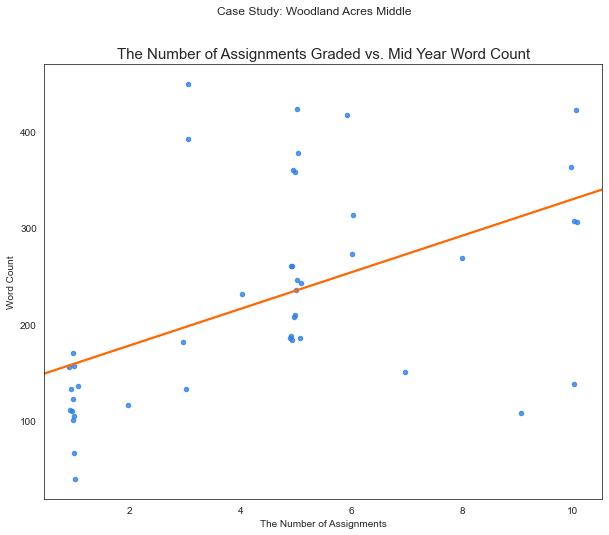

In [48]:
sns.set_style(style='white')
plt.figure(figsize = (10,8))
sns.regplot(wam['num_asgmt'],wam['midyear_wordcount'], order = 1,
            scatter_kws={"color": "#2f7fe2",'s':20}, truncate = False, x_jitter=.1,marker='o',
            line_kws={"color": "#ff6800"}, ci=None)
plt.xlabel('The Number of Assignments')
plt.ylabel('Word Count')
plt.title("The Number of Assignments Graded vs. Mid Year Word Count", fontsize=15)
plt.suptitle("Case Study: Woodland Acres Middle")
plt.savefig(os.path.join(path,'wam_num asgmt vs midyear word count.png'))
plt.show()

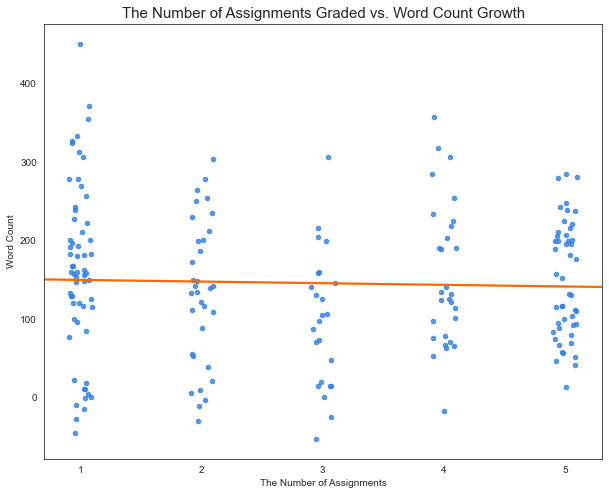

In [42]:
sns.set_style(style='white')
plt.figure(figsize = (10,8))
sns.regplot(gpm['num_asgmt'],gpm['growth'], order = 1,
            scatter_kws={"color": "#2f7fe2",'s':20}, truncate = False, x_jitter=.1,marker='o',
            line_kws={"color": "#ff6800"}, ci=None)
plt.xlabel('The Number of Assignments')
plt.ylabel('Word Count')
plt.title("The Number of Assignments Graded vs. Word Count Growth", fontsize=15)
# plt.savefig(os.path.join(path,'Assignments vs Word Count.png'))
plt.show()

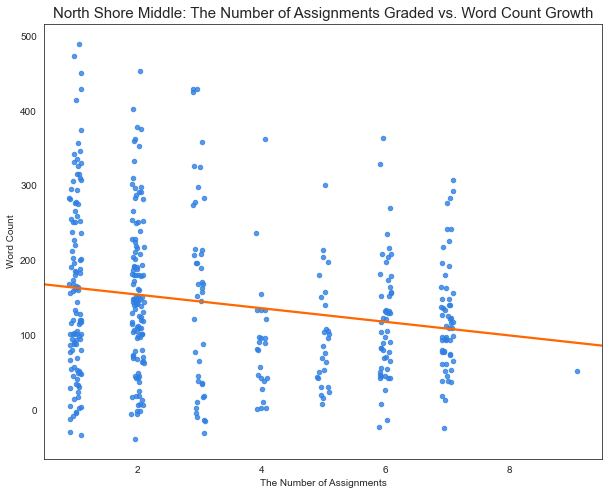

In [40]:
sns.set_style(style='white')
plt.figure(figsize = (10,8))
sns.regplot(nsm['num_asgmt'],nsm['growth'], order = 1,
            scatter_kws={"color": "#2f7fe2",'s':20}, truncate = False, x_jitter=.1,marker='o',
            line_kws={"color": "#ff6800"}, ci=None)
plt.xlabel('The Number of Assignments')
plt.ylabel('Word Count')
plt.title("North Shore Middle: The Number of Assignments Graded vs. Word Count Growth", fontsize=15)
# plt.savefig(os.path.join(path,'Assignments vs Word Count.png'))
plt.show()